In [1]:
import numpy as np
import pandas as pd
import importlib.util
from pathlib import Path
import json

import search_results_lib as srl

In [2]:
df = pd.read_csv("responses.csv", sep='\t', header=0)
df[df['pagina'] == 12]

pagina                pregunta incisos
0       12            tipo_entidad       h
1       12          origen_entidad       b
2       12               proposito       d
3       12  informacion_presentada       a
4       12                  vision   a b d
5       12           consecuencias       c
6       12             que_muestra       c
7       12               intencion       b
8       12      localidad_problema       b
9       12            involucrados       f
10      12              formalidad       a
11      12         nivel_educacion       b
12      12                    tono       b
13      12               emociones       h
14      12            tipo_entidad       h
15      12          origen_entidad       b
16      12               proposito       d
17      12  informacion_presentada       a
18      12                  vision       d
19      12           consecuencias       c
20      12             que_muestra       d
21      12               intencion       a
22      12      localidad_problema       b
23      12            involucrados       b
24      12              formalidad       a
25      12         nivel_educacion       b
26      12                    tono       b
27      12               emociones       h
28      12            tipo_entidad       h
29      12          origen_entidad       b
30      12               proposito       d
31      12  informacion_presentada       a
32      12                  vision       d
33      12           consecuencias       c
34      12             que_muestra       c
35      12               intencion       a
36      12      localidad_problema       b
37      12            involucrados       c
38      12              formalidad       a
39      12         nivel_educacion       b
40      12                    tono       b
41      12               emociones       h

In [3]:
multi_choice = ['proposito',
                'informacion_presentada',
                'consecuencias',
                'intencion',
                'localidad_problema',
                'involucrados',
                'emociones']

possible_answers = {"tipo_entidad": ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i'],
                    "origen_entidad": ['a', 'b'],
                    "vision": ['a', 'b', 'c', 'd'],
                    'que_muestra': ['a', 'b', 'c', 'd'],
                    'formalidad': ['a', 'b'],
                    'nivel_educacion': ['a', 'b'],
                    'tono': ['a', 'b'],
                    "proposito": ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i'],
                    "informacion_presentada": ['a', 'b', 'c'],
                    "consecuencias": ['a', 'b', 'c', 'd'],
                    "intencion": ['a', 'b', 'c', 'd', 'e', 'f'],
                    "localidad_problema": ['a', 'b', 'c'],
                    "involucrados": ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'],
                    "emociones": ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
                    }
single_questions = [q for q in possible_answers if q not in multi_choice]

In [ ]:
def parse_choices(x):
    '''
    Convierte una cadena de respuestas múltiples en una lista de respuestas.
    '''
    if pd.isna(x):
        return []
    s = str(x).strip().lower()
    if not s:
        return []
    else:
        return sorted(set(s.split()))

def analyze_pages(df, multi_choice_questions, possible_answers):
    '''
    Analiza las respuestas a las preguntas para cada pagina.
    '''
    df2 = df.copy()
    df2['incisos'] = df2['incisos'].apply(parse_choices)
    
    single_questions = sorted(set(df2['pregunta'].unique()) - set(multi_choice_questions))
    
    rows = []
    for q in single_questions:
    #for q in sorted(df2['pregunta'].unique()):
        allowed = possible_answers.get(q, [])
        sub = df2[df2['pregunta'].eq(q)].copy()
        n_by_page = sub.groupby('pagina').size().rename('n') # numero de respuestas a la pregunta por pagina
        exploded = sub[['pagina', 'incisos']].explode('incisos')
        exploded = exploded.dropna(subset=['incisos'])
        counts = exploded.groupby(['pagina', 'incisos']).size().rename('count')
        wide_counts = counts.unstack('incisos').reindex(columns=allowed, fill_value=0).fillna(0)
        winners = wide_counts.idxmax(axis=1)

        onehot = pd.DataFrame(0, index=wide_counts.index, columns=wide_counts.columns, dtype=int)

        # opcional: si una fila es todo 0, dejarla toda en 0 (sin ganador)
        has_signal = wide_counts.ne(0).any(axis=1)
        winners = winners.where(has_signal, None)

        valid = winners.notna()
        r = np.where(valid)[0]
        c = onehot.columns.get_indexer(winners[valid])
        onehot.values[r, c] = 1
        # --------------------------------------

        onehot.columns = [f"{q}__{c}" for c in onehot.columns]
        rows.append(onehot)
    single_summary = pd.concat(rows, axis=1) if rows else pd.DataFrame()
    mx = single_summary.max(axis=1)
    single_summary = single_summary.eq(mx, axis=0).astype(int)

    rows = []
    for q in multi_choice_questions:
    #for q in sorted(df2['pregunta'].unique()):
        allowed = possible_answers.get(q, [])
        sub = df2[df2['pregunta'].eq(q)].copy()
        
        n_by_page = sub.groupby('pagina').size().rename('n') # numero de respuestas a la pregunta por pagina
    
        exploded = sub[['pagina', 'incisos']].explode('incisos')
        exploded = exploded.dropna(subset=['incisos'])
        counts = exploded.groupby(['pagina', 'incisos']).size().rename('count')
        wide_counts = counts.unstack('incisos').reindex(columns=allowed, fill_value=0).fillna(0)
        wide_pct = wide_counts.div(n_by_page, axis=0).fillna(0)
        wide_pct.columns = [f"{q}__{c}" for c in wide_pct.columns]
        rows.append(wide_pct)

    multi_summary = pd.concat(rows, axis=1) if rows else pd.DataFrame()
    return pd.concat([single_summary, multi_summary], axis=1)
    #return multi_summary


In [5]:
analyze_pages(df, multi_choice, possible_answers)

formalidad__a  formalidad__b  nivel_educacion__a  nivel_educacion__b  \
pagina                                                                         
0                   1              0                   0                   1   
1                   1              0                   0                   1   
2                   1              0                   0                   1   
3                   1              0                   0                   1   
4                   1              0                   0                   1   
...               ...            ...                 ...                 ...   
592                 1              0                   0                   1   
593                 1              0                   0                   1   
594                 1              0                   0                   1   
595                 1              0                   0                   1   
596                 1              0                   0                   1   

        origen_entidad__a  origen_entidad__b  que_muestra__a  que_muestra__b  \
pagina                                                                         
0                       0                  1               0               0   
1                       0                  1               0               0   
2                       0                  1               0               0   
3                       0                  1               0               0   
4                       0                  1               0               0   
...                   ...                ...             ...             ...   
592                     1                  0               0               0   
593                     0                  1               0               0   
594                     1                  0               0               0   
595                     0                  1               0               0   
596                     0                  1               0               0   

        que_muestra__c  que_muestra__d  ...  involucrados__g  involucrados__h  \
pagina                                  ...                                     
0                    0               1  ...         0.000000         0.000000   
1                    1               0  ...         0.000000         0.000000   
2                    0               1  ...         0.000000         0.000000   
3                    1               0  ...         0.000000         0.333333   
4                    0               1  ...         0.333333         0.000000   
...                ...             ...  ...              ...              ...   
592                  0               1  ...         0.000000         0.000000   
593                  0               1  ...         0.000000         0.000000   
594                  1               0  ...         0.000000         0.333333   
595                  1               0  ...         0.000000         0.000000   
596                  0               1  ...         0.000000         0.000000   

        emociones__a  emociones__b  emociones__c  emociones__d  emociones__e  \
pagina                                                                         
0                0.0           0.0           0.0      0.000000      0.000000   
1                0.0           0.0           0.0      0.000000      0.333333   
2                0.0           0.0           0.0      0.000000      0.000000   
3                0.0           0.0           0.0      0.000000      0.000000   
4                0.0           0.0           0.0      0.333333      0.333333   
...              ...           ...           ...           ...           ...   
592              0.0           0.0           0.0      0.000000      0.333333   
593              0.0           0.0           0.0      0.000000      0.000000   
594              0.0           0.0           0.0      0.000000      0.00

In [6]:
# Leer el archivo JSON guardado
Nombre_Archivo = f"../buscador/resultados/resultados_corrupcion.json"

with open(Nombre_Archivo, "r") as file:
    resultados = json.load(file)

# Leer el archivo JSON guardado
Nombre_Archivo = f"../buscador/resultados/res_unicos_corrupcion.json"

with open(Nombre_Archivo, "r") as file:
    all_hrefs = json.load(file)

In [7]:
# humano < 75% precision llama < 0.6
bad_questions = ['proposito__d', 'tono', 'intencion__c', 'que_muestra', 'proposito__g', 'consecuencias__c', 'proposito__b', 'involucrados__f', 'emociones__h', 'formalidad', 'involucrados__b', 'localidad_problema__a']
# humano < 75% precision llama <= 0.6
#bad_questions = ['proposito__d', 'tono', 'intencion__c', 'que_muestra', 'proposito__g', 'consecuencias__c', 'proposito__b', 'involucrados__f', 'origen_entidad', 'intencion__b', 'emociones__h', 'vision', 'intencion__a', 'formalidad', 'involucrados__b', 'tipo_entidad', 'localidad_problema__a', 'localidad_problema__b']
#bad_questions.remove('emociones__h') # se elimina emocion neutral
for q in bad_questions:
    if "__" not in q:
        bad_questions.remove(q)
        for i in possible_answers.get(q, []):
            bad_questions.append(f"{q}__{i}")

In [8]:
df_forms = analyze_pages(df, multi_choice, possible_answers)
df_forms = df_forms.drop(columns=bad_questions)
df_forms

nivel_educacion__a  nivel_educacion__b  origen_entidad__a  \
pagina                                                              
0                        0                   1                  0   
1                        0                   1                  0   
2                        0                   1                  0   
3                        0                   1                  0   
4                        0                   1                  0   
...                    ...                 ...                ...   
592                      0                   1                  1   
593                      0                   1                  0   
594                      0                   1                  1   
595                      0                   1                  0   
596                      0                   1                  0   

        origen_entidad__b  tipo_entidad__a  tipo_entidad__b  tipo_entidad__c  \
pagina                                                                         
0                       1                0                0                0   
1                       1                0                0                0   
2                       1                0                0                0   
3                       1                0                0                1   
4                       1                0                0                0   
...                   ...              ...              ...              ...   
592                     0                0                0                0   
593                     1                0                0                0   
594                     0                0                1                0   
595                     1                0                0                0   
596                     1                0                0                0   

        tipo_entidad__d  tipo_entidad__e  tipo_entidad__f  ...  \
pagina                                                     ...   
0                     0                0                0  ...   
1                     0                0                0  ...   
2                     0                0                0  ...   
3                     0                0                0  ...   
4                     0                0                0  ...   
...                 ...              ...              ...  ...   
592                   1                0                0  ...   
593                   0                0                0  ...   
594                   0                0                0  ...   
595                   0                0                0  ...   
596                   0                0                0  ...   

        involucrados__e  involucrados__g  involucrados__h  emociones__a  \
pagina                                                                    
0              0.000000         0.000000         0.000000           0.0   
1              0.333333         0.000000         0.000000           0.0   
2              0.666667         0.000000         0.000000           0.0   
3              0.333333         0.000000         0.333333           0.0   
4              0.000000         0.333333         0.000000           0.0   
...                 ...              ...              ...           ...   
592            0.333333         0.000000         0.000000           0.0   
593            0.000000         0.000000         0.000000           0.0   
594            0.333333         0.000000         0.333333           0.0   
595            0.333333         0.000000         0.000000           0.0   
596            0.000000         0.000000         0.000000           0.0   

        emociones__b  emociones__c  emociones__d  emociones__e  emociones__f  \
pagina                                                                         
0                0.0           0.0      0.000000      0.000000      0.0000

In [9]:
df_forms.isna().sum()

nivel_educacion__a           0
nivel_educacion__b           0
origen_entidad__a            0
origen_entidad__b            0
tipo_entidad__a              0
tipo_entidad__b              0
tipo_entidad__c              0
tipo_entidad__d              0
tipo_entidad__e              0
tipo_entidad__f              0
tipo_entidad__g              0
tipo_entidad__h              0
tipo_entidad__i              0
vision__a                    0
vision__b                    0
vision__c                    0
vision__d                    0
proposito__a                 0
proposito__c                 0
proposito__e                 0
proposito__f                 0
proposito__h                 0
proposito__i                 0
informacion_presentada__a    0
informacion_presentada__b    0
informacion_presentada__c    0
consecuencias__a             0
consecuencias__b             0
consecuencias__d             0
intencion__a                 0
intencion__b                 0
intencion__d                 0
intencio

In [10]:
bad_labels = ['emotion_others', 'sentiment_NEU', 'irony_not ironic']
df_robertuito = pd.read_csv("./robertuito/robertuito_all_results.csv").drop(columns=bad_labels)
df_robertuito.set_index('pagina', inplace=True)
df_robertuito

emotion_joy  emotion_sadness  emotion_anger  emotion_fear  \
pagina                                                              
12             0.00             0.02           0.75           0.0   
571            0.00             0.00           0.00           0.0   
200            0.00             0.00           0.00           0.0   
394            0.00             0.00           0.00           0.0   
397            0.00             0.01           0.04           0.0   
...             ...              ...            ...           ...   
501            0.01             0.00           0.00           0.0   
9              0.00             0.00           0.00           0.0   
575            0.00             0.01           0.64           0.0   
373            0.01             0.02           0.39           0.0   
462            0.00             0.00           0.00           0.0   

        emotion_surprise  emotion_disgust  sentiment_NEG  sentiment_POS  \
pagina                                                                    
12                  0.01             0.09           0.84           0.01   
571                 0.00             0.00           0.09           0.05   
200                 0.00             0.00           0.07           0.12   
394                 0.00             0.00           0.07           0.15   
397                 0.00             0.00           0.65           0.03   
...                  ...              ...            ...            ...   
501                 0.00             0.00           0.10           0.14   
9                   0.00             0.00           0.17           0.09   
575                 0.00             0.05           0.32           0.03   
373                 0.00             0.05           0.64           0.04   
462                 0.00             0.00           0.11           0.15   

        hate_speech_hateful  hate_speech_targeted  hate_speech_aggressive  \
pagina                                                                      
12                     0.04                  0.01                    0.02   
571                    0.03                  0.01                    0.02   
200                    0.02                  0.01                    0.01   
394                    0.02                  0.01                    0.02   
397                    0.03                  0.01                    0.03   
...                     ...                   ...                     ...   
501                    0.02                  0.01                    0.01   
9                      0.02                  0.00                    0.01   
575                    0.02                  0.00                    0.02   
373                    0.04                  0.02                    0.03   
462                    0.02                  0.01                    0.01   

        irony_ironic  
pagina                
12              0.00  
571             0.13  
200             0.01  
394             0.01  
397             0.00  
...              ...  
501             0.08  
9               0.00  
575             0.01  
373             0.03  
462             0.00  

[551 rows x 12 columns]

In [11]:
max_len = max([len(r['search_results']['results']) for r in resultados])
rankings = {}
for r in resultados:
    pages = [all_hrefs.index(res['href']) for res in r['search_results']['results']]
    if len(pages) < max_len:
        diff = max_len - len(pages)
        pages += [np.nan] * diff
    rankings[r['country']] = pages
df_rankings = pd.DataFrame(rankings).T
df_rankings.drop('Puerto Rico', inplace=True)
df_rankings

0      1      2      3      4      5      6      7   \
Argentina             0.0    1.0    2.0    3.0    4.0    5.0    6.0    7.0   
Bolivia               0.0    1.0    3.0    5.0    2.0    4.0   28.0  100.0   
Chile                 1.0    4.0  159.0  160.0    3.0    2.0    5.0   33.0   
Colombia              0.0    1.0    3.0    2.0    4.0    5.0   28.0    8.0   
Costa Rica            1.0    3.0    2.0    4.0    5.0  158.0   28.0  269.0   
Cuba                  0.0    1.0    2.0    3.0    4.0    5.0   28.0   55.0   
Ecuador               1.0    3.0  159.0    5.0  317.0    2.0    4.0   63.0   
El Salvador           0.0    1.0    2.0    3.0    4.0    5.0   28.0  354.0   
Guatemala             0.0    1.0    2.0    3.0    5.0    4.0   49.0  116.0   
Honduras              0.0    1.0    2.0    3.0    5.0    4.0   28.0  385.0   
Mexico                0.0    1.0    3.0    5.0    2.0   28.0    4.0  314.0   
Nicaragua             0.0    1.0    2.0    3.0    4.0    5.0   28.0  440.0   
Panama                0.0    1.0    2.0    3.0    4.0    5.0   28.0  447.0   
Paraguay            457.0    1.0  159.0    2.0    3.0  458.0    5.0    4.0   
Peru                  0.0    1.0    3.0    2.0    4.0    5.0  106.0   28.0   
Dominican Republic    0.0    1.0    3.0    2.0    4.0    5.0  106.0  120.0   
Uruguay               0.0    1.0    2.0    4.0    3.0    5.0   28.0  306.0   
Venezuela             0.0    1.0  115.0    3.0    2.0   28.0    5.0    4.0   
Spain                 1.0  159.0    4.0    2.0    3.0   33.0    5.0  563.0   

                       8      9   ...     90     91     92     93     94  \
Argentina             8.0    9.0  ...   90.0   91.0   92.0   93.0   94.0   
Bolivia              55.0  101.0  ...  153.0  154.0  155.0   97.0  156.0   
Chile               161.0  144.0  ...   51.0  208.0  116.0  209.0  125.0   
Colombia            119.0   43.0  ...  266.0   75.0  144.0  132.0  124.0   
Costa Rica          270.0  271.0  ...  137.0   59.0   82.0  125.0  155.0   
Cuba                 43.0    8.0  ...  315.0   30.0  299.0  141.0  153.0   
Ecuador             318.0  319.0  ...   68.0  136.0  353.0   96.0  138.0   
El Salvador          55.0   43.0  ...  143.0  158.0  138.0  140.0  209.0   
Guatemala            28.0  294.0  ...  285.0  382.0  312.0  146.0   51.0   
Honduras            386.0  106.0  ...  229.0  344.0   51.0  146.0  381.0   
Mexico                8.0  123.0  ...  437.0  132.0   64.0  360.0   59.0   
Nicaragua           441.0   55.0  ...  150.0  133.0  360.0  361.0  313.0   
Panama              448.0   43.0  ...  137.0  353.0  177.0  455.0  313.0   
Paraguay            143.0  459.0  ...  158.0  312.0  131.0  454.0  344.0   
Peru                  8.0  472.0  ...  510.0  511.0  512.0  513.0   68.0   
Dominican Republic   28.0  527.0  ...  300.0  475.0   79.0  361.0  127.0   
Uruguay             536.0  537.0  ...  144.0   32.0  548.0  312.0   86.0   
Venezuela            73.0   21.0  ...   99.0  129.0  472.0  285.0  360.0   
Spain                87.0    8.0  ...  348.0  307.0  123.0   65.0  594.0   

                       95     96     97     98     99  
Argentina            95.0   96.0   97.0   98.0   99.0  
Bolivia             157.0   65.0  158.0   59.0    NaN  
Chile               210.0  211.0  212.0  139.0   82.0  
Colombia            146.0  267.0  131.0   86.0  268.0  
Costa Rica          298.0  299.0  300.0    NaN    NaN  
Cuba                316.0   32.0  101.0    NaN    NaN  
Ecuador              58.0  153.0    NaN    NaN    NaN  
El Salvador          53.0  314.0   77.0  362.0  203.0  
Guatemala           131.0  383.0  166.0  360.0  384.0  
Honduras             99.0  145.0  397.0    NaN    NaN  
Mexico              361.0   99.0  438.0  439.0   66.0  
Nicaragua           445.0   32.0  446.0  300.0  153.0  
Panama              406.0   64.0  456.0  396.0  146.0  
Paraguay            294.0  362.0  396.0  471.0  165.0  
Peru                 59.0  146.0  144.0  514.0  515.0  
Dominican Republic  344.0  143.0  155.0   31.

Argentina  1       1.0
           2       2.0
           3       3.0
           4       4.0
           5       5.0
                 ...  
Spain      95    595.0
           96     18.0
           97     86.0
           98    596.0
           99     12.0
Length: 1700, dtype: float64

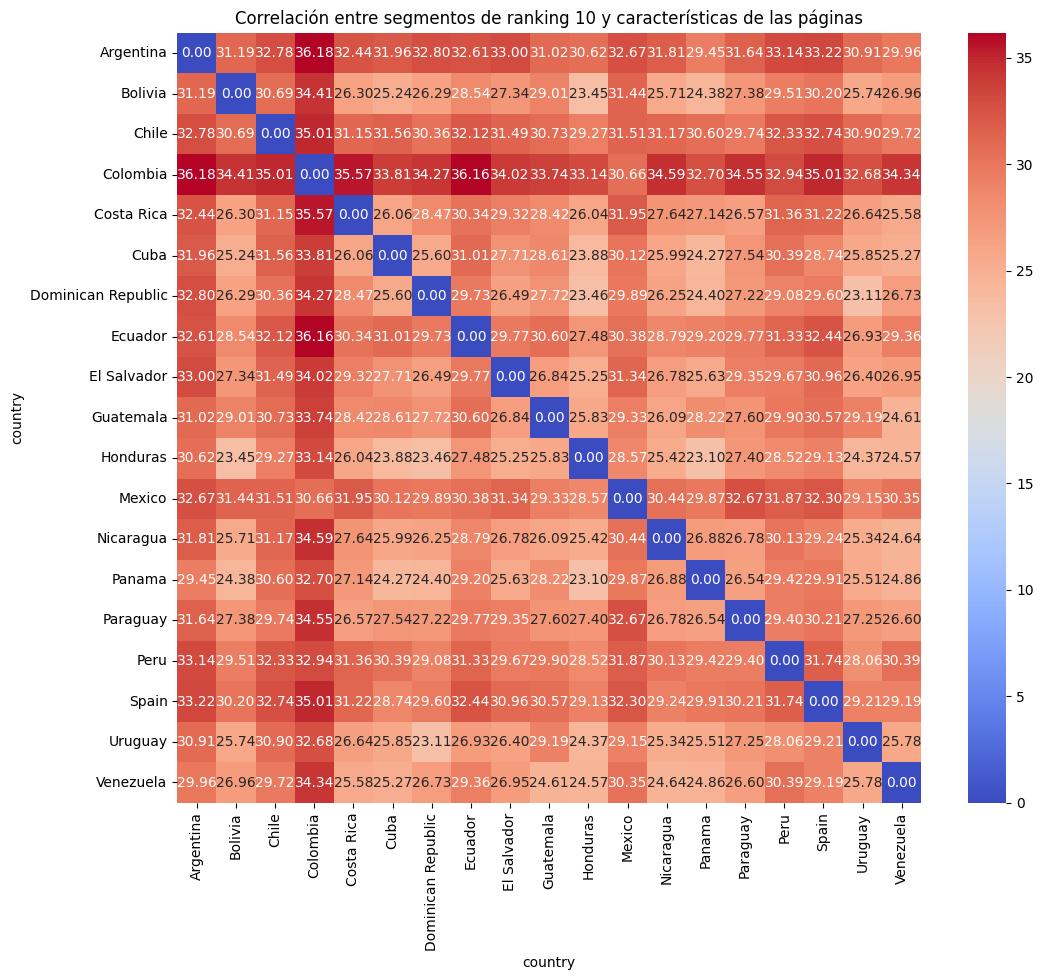

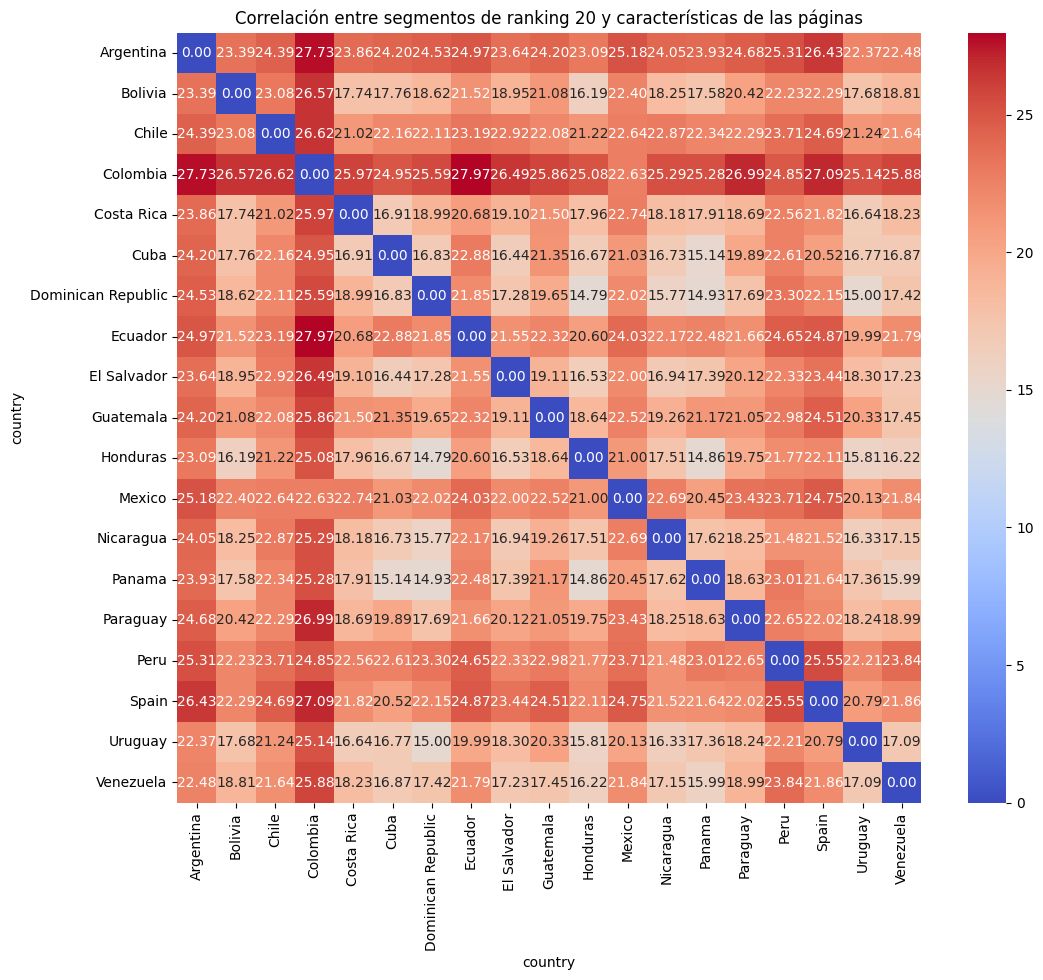

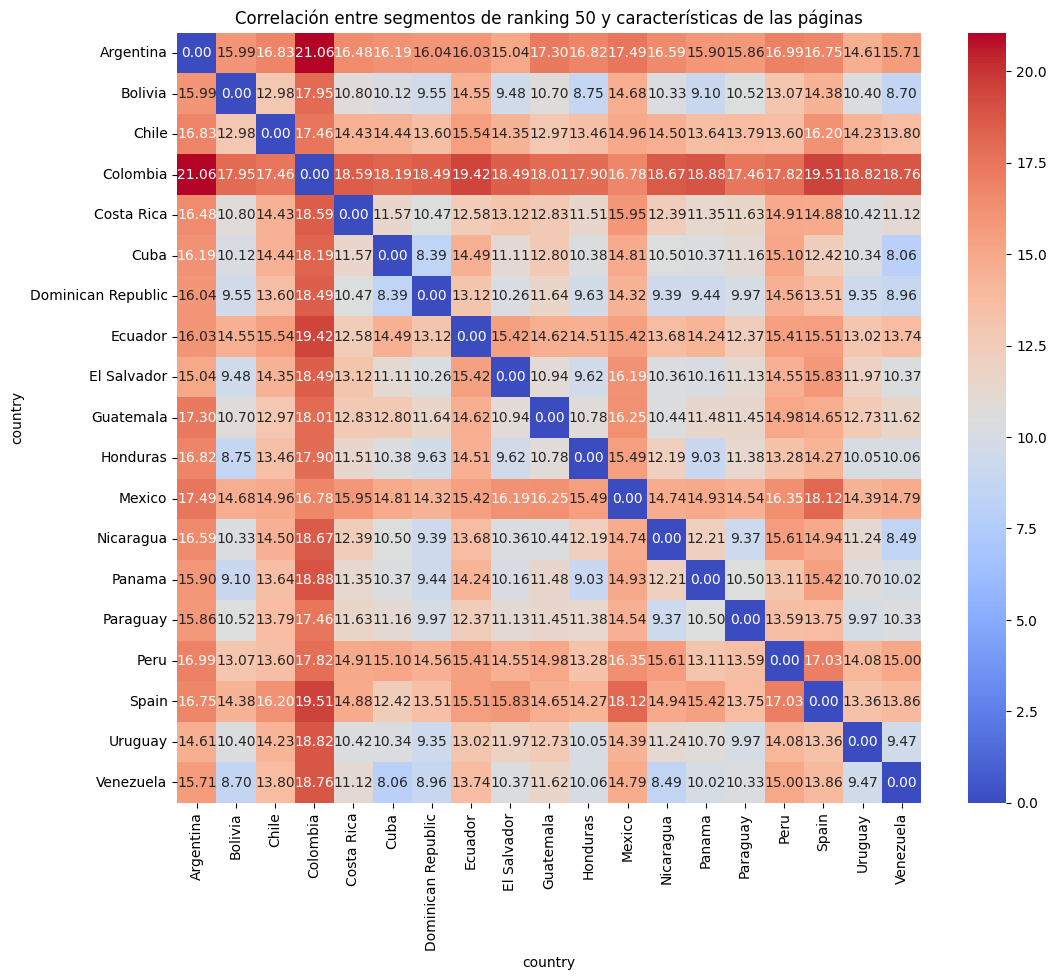

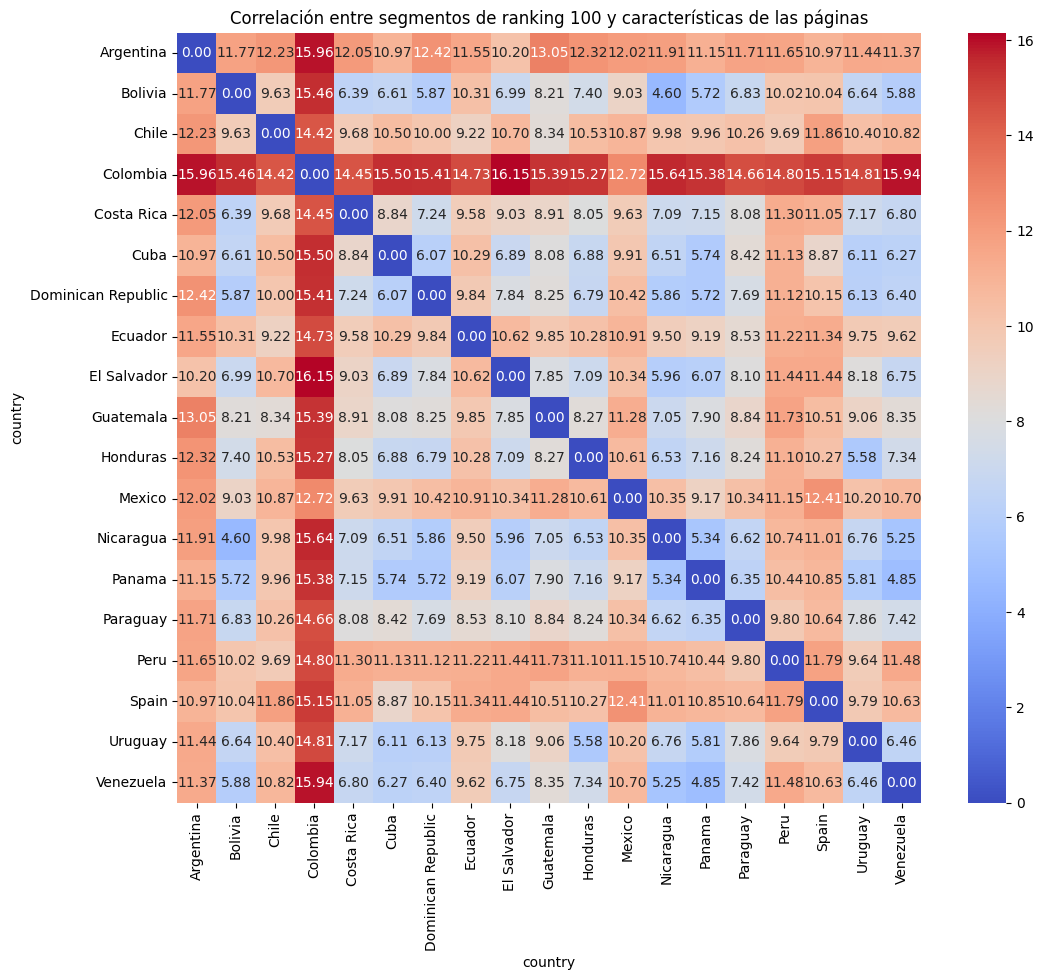

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

segs = [10,20,50,100]
one_hot_cols = [col for col in df_forms.columns if df_forms[col].isin([0, 1]).all()]
for s in segs:
    corr_rankings = srl.compute_rank_feature_distance(df_rankings, df_forms, segment_size=s, onehot_cols=one_hot_cols)[0]
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_rankings, annot=True, fmt=".2f", cmap='coolwarm', vmin=0, vmax=corr_rankings.values.max())
    plt.title(f'Correlación entre segmentos de ranking {s} y características de las páginas')
    plt.show()

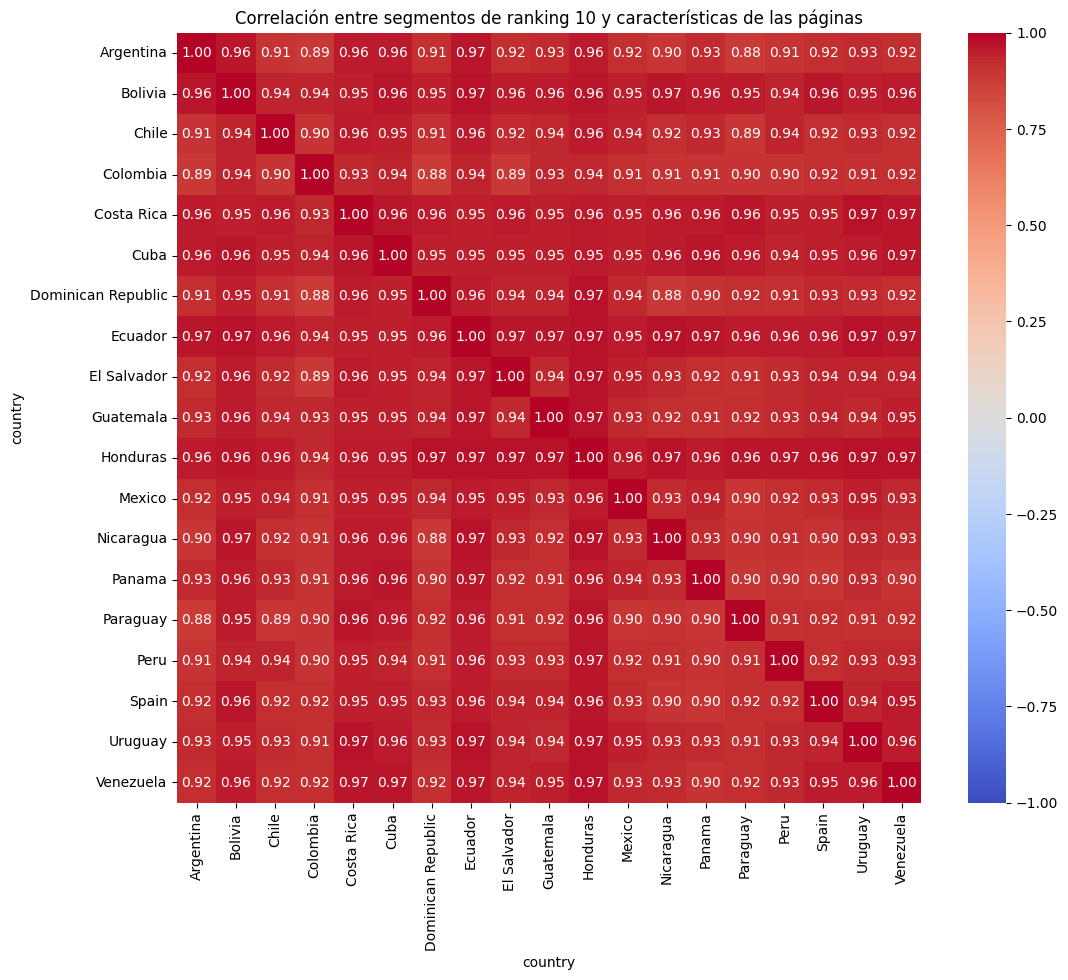

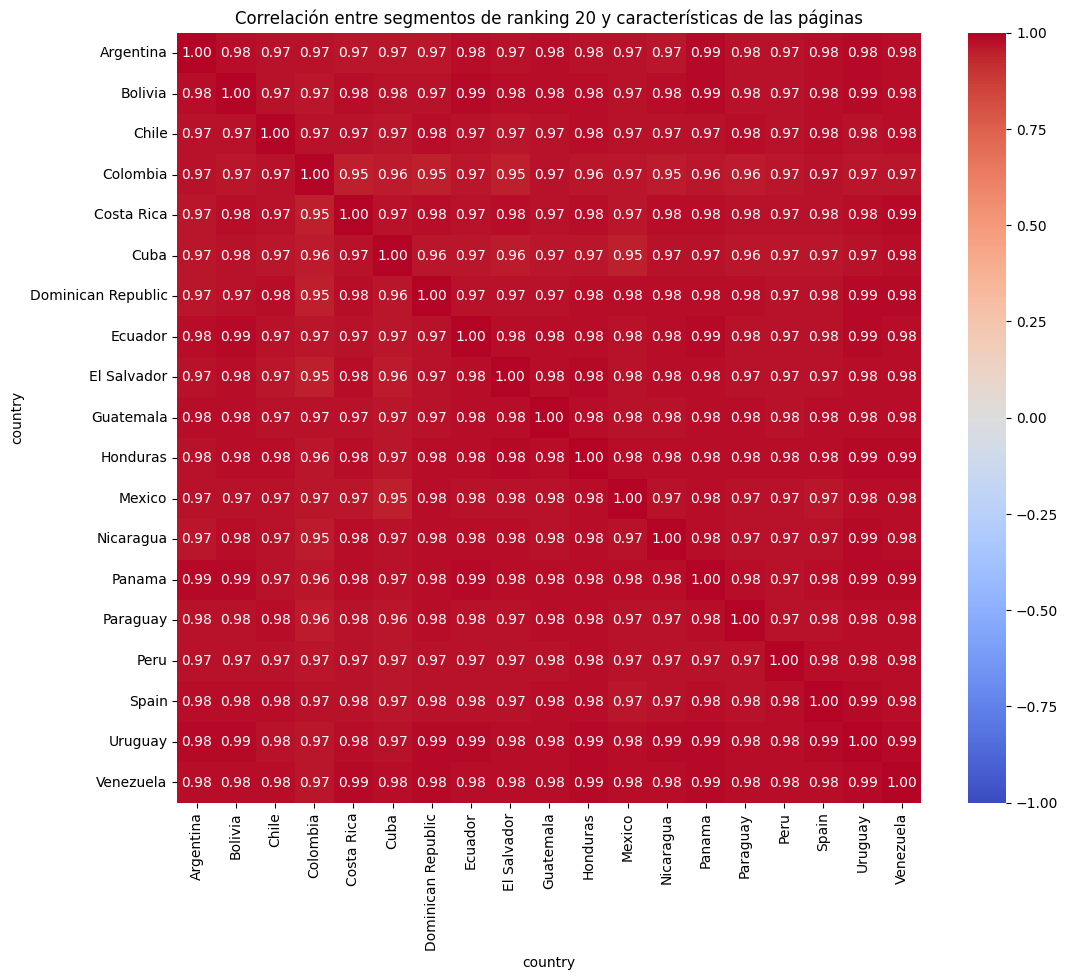

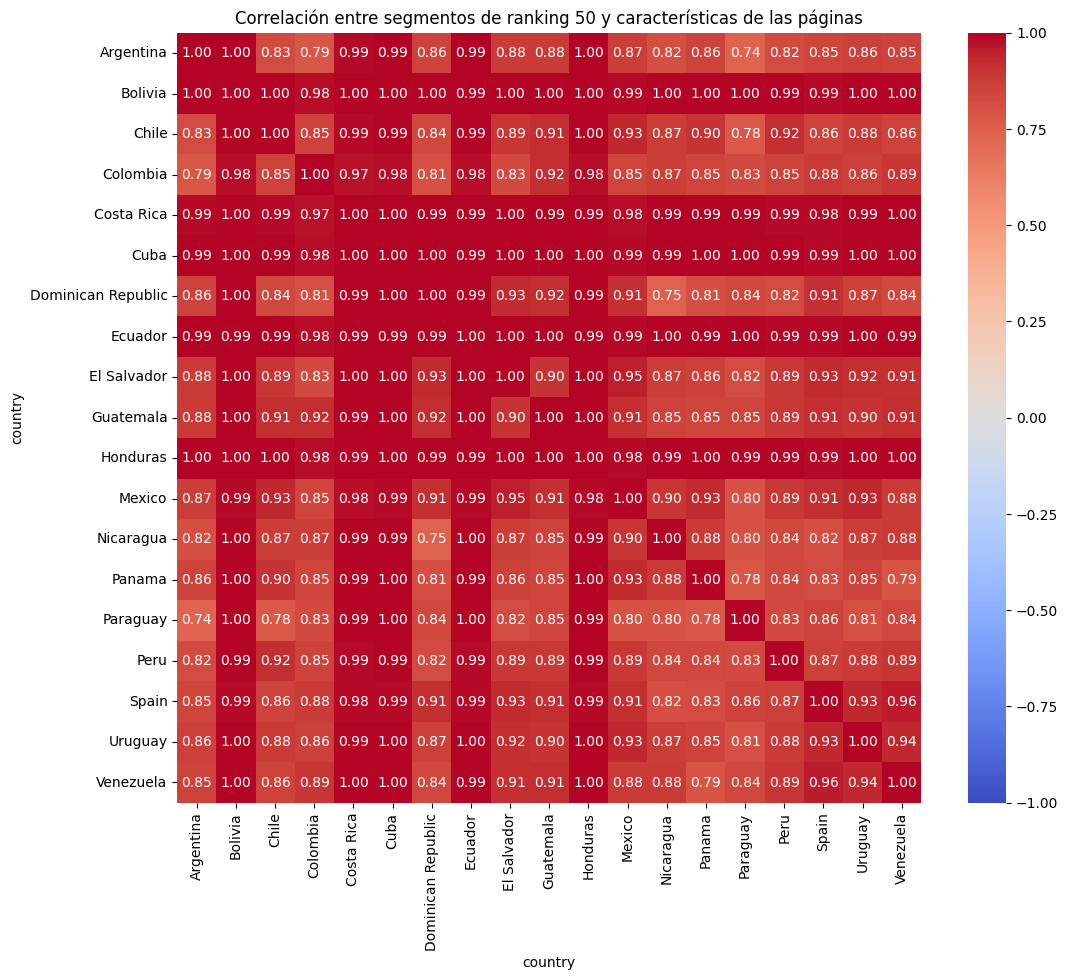

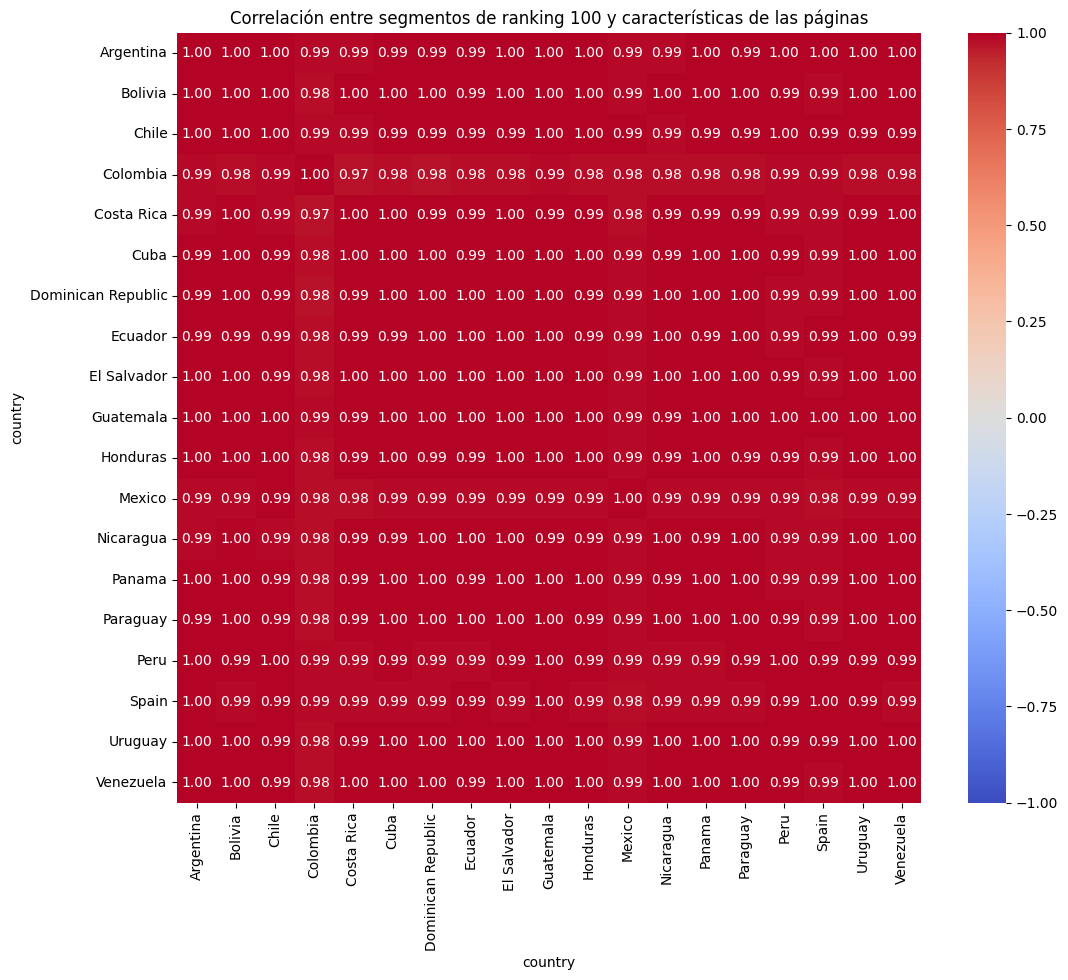

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt

segs = [10,20,50,100]
for s in segs:
    corr_rankings = compute_rank_feature_correlation(df_rankings, df_forms, s, 50)
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_rankings, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'Correlación entre segmentos de ranking {s} y características de las páginas')
    plt.show()


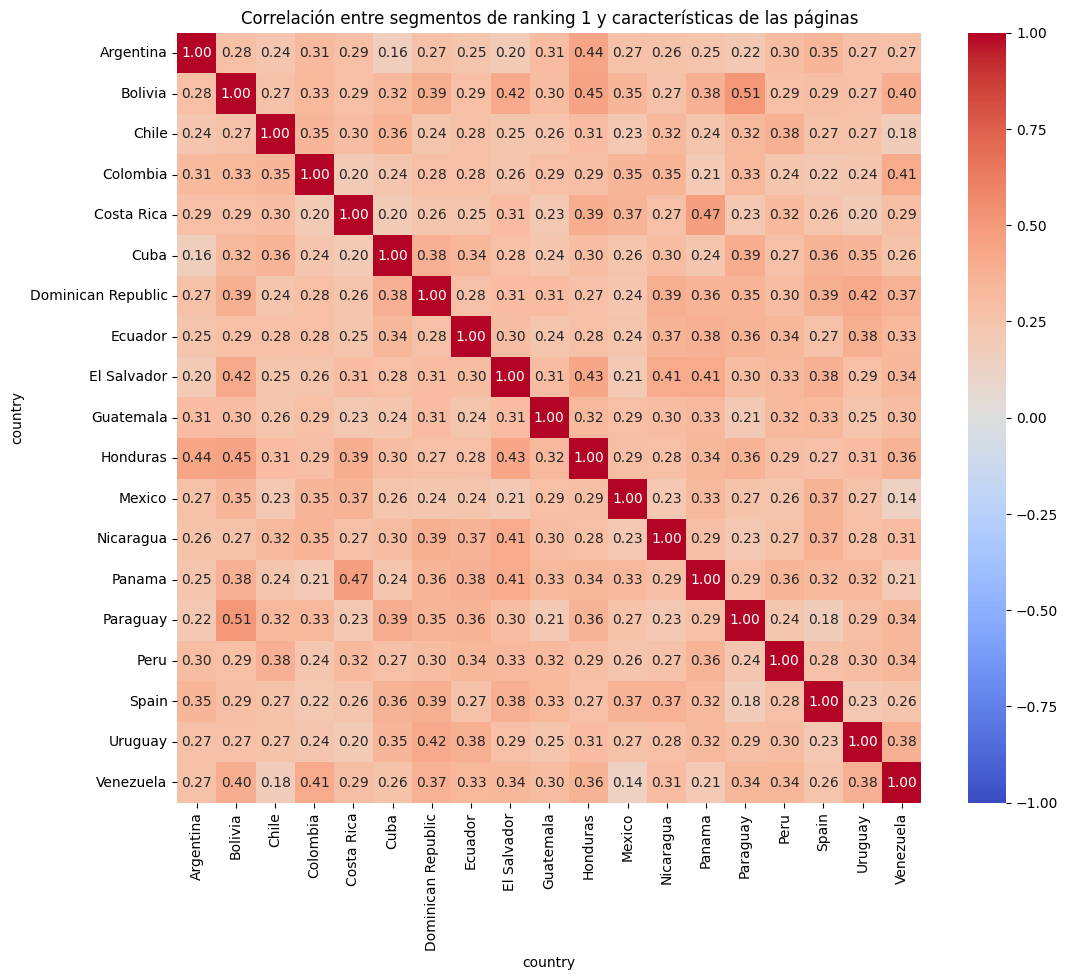

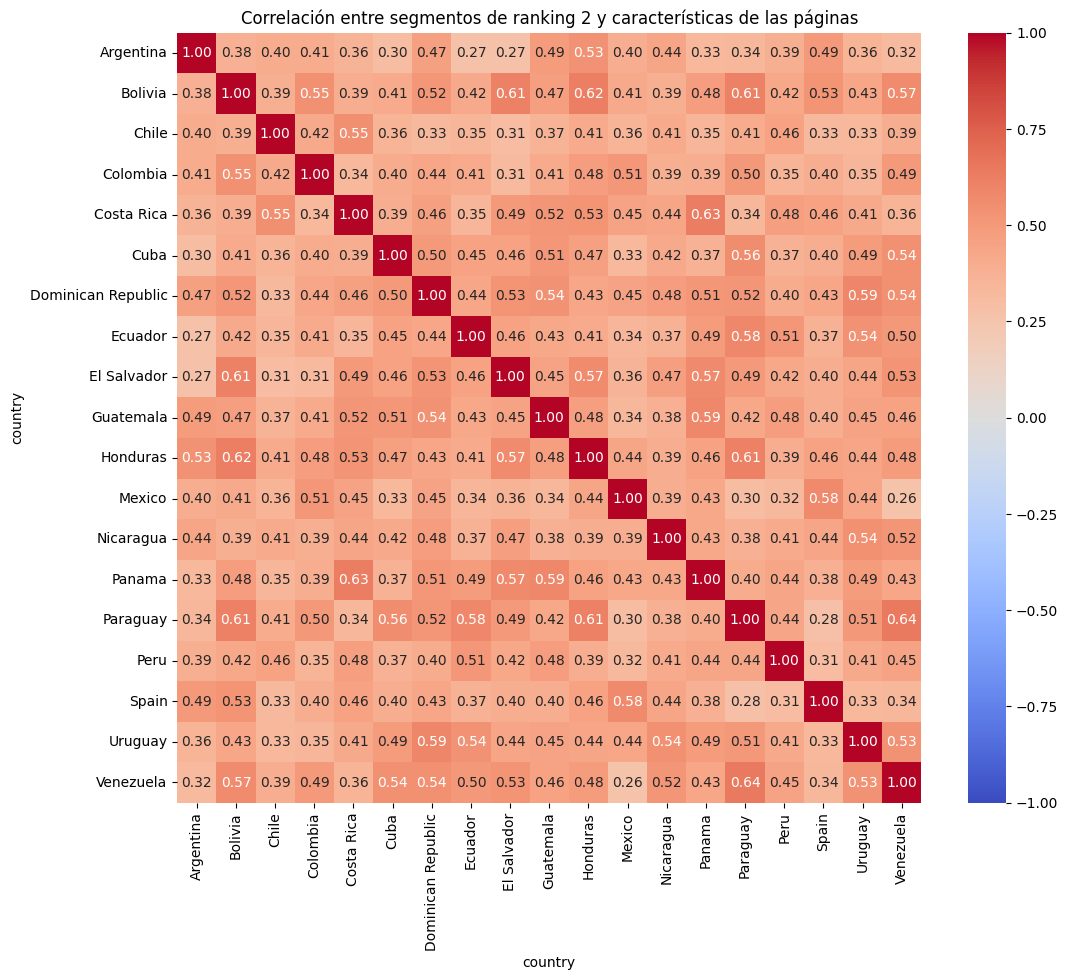

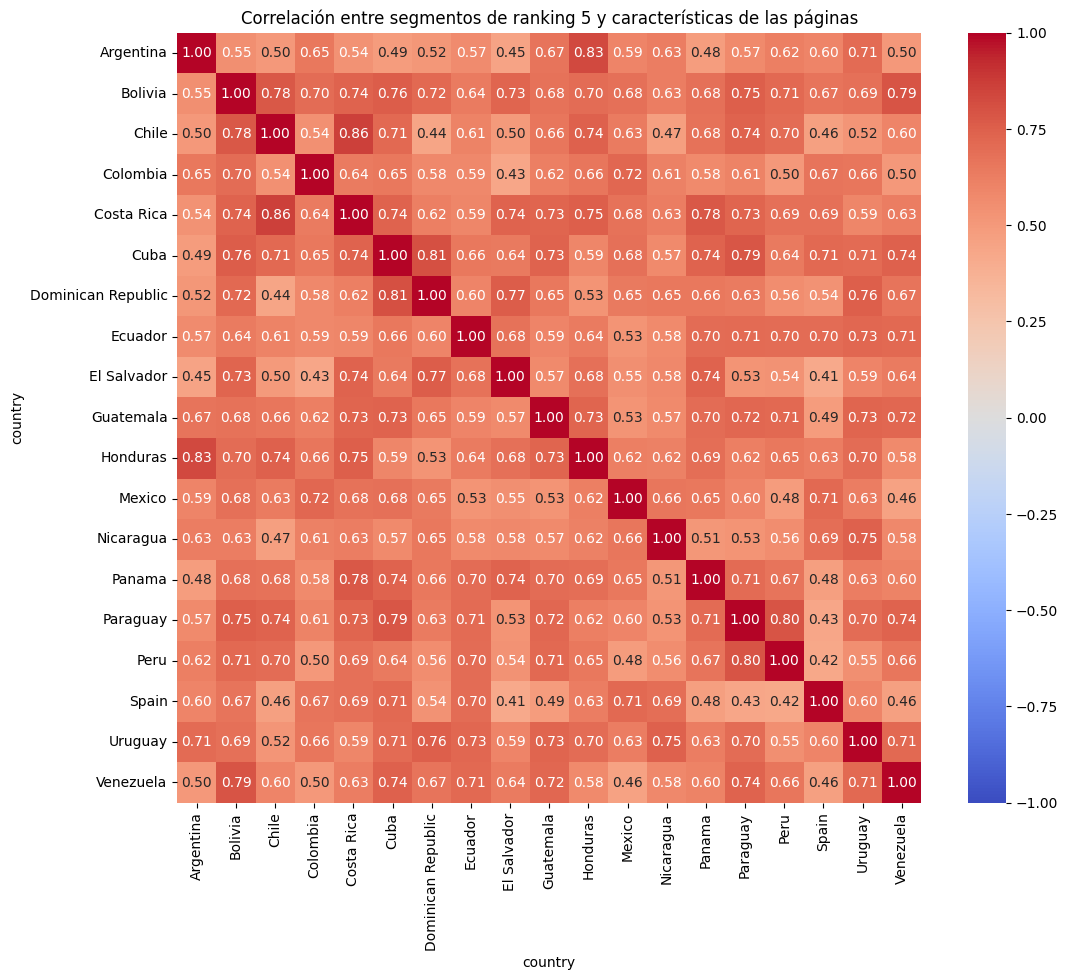

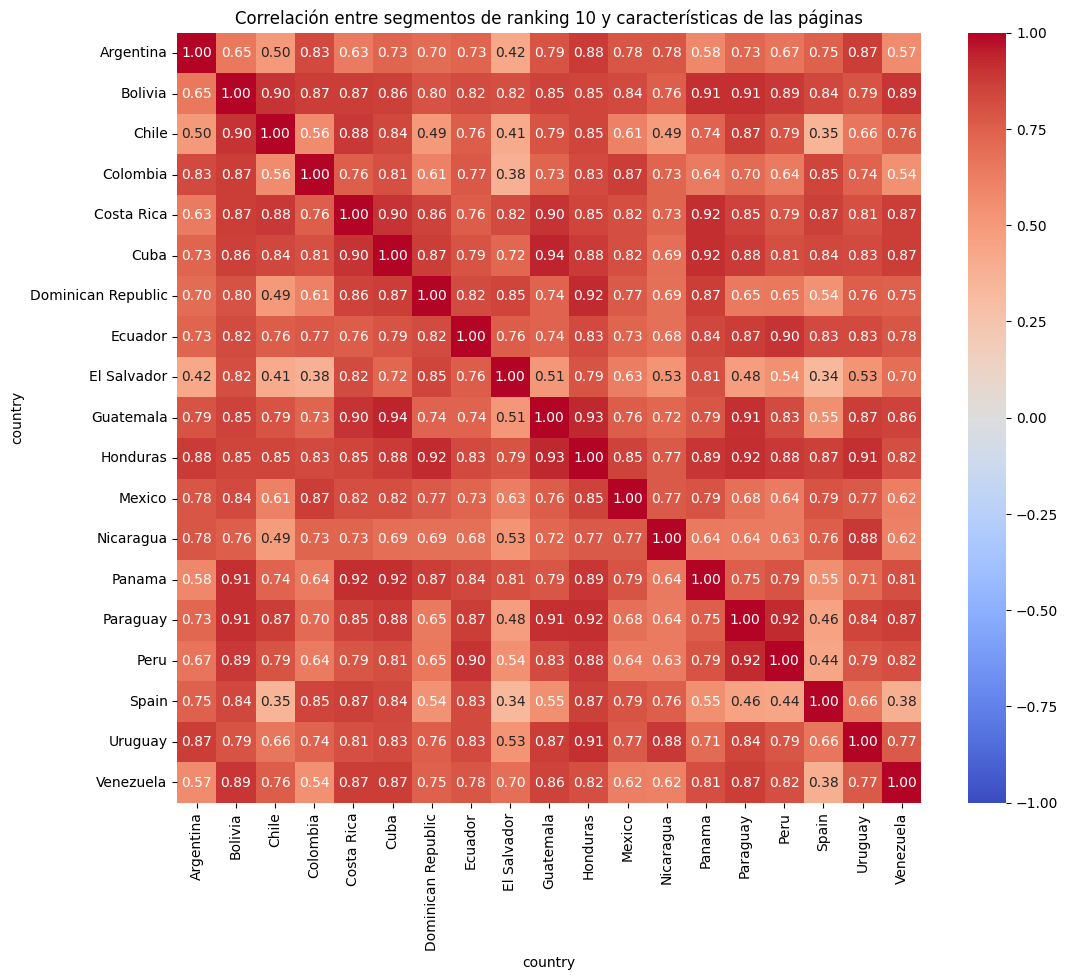

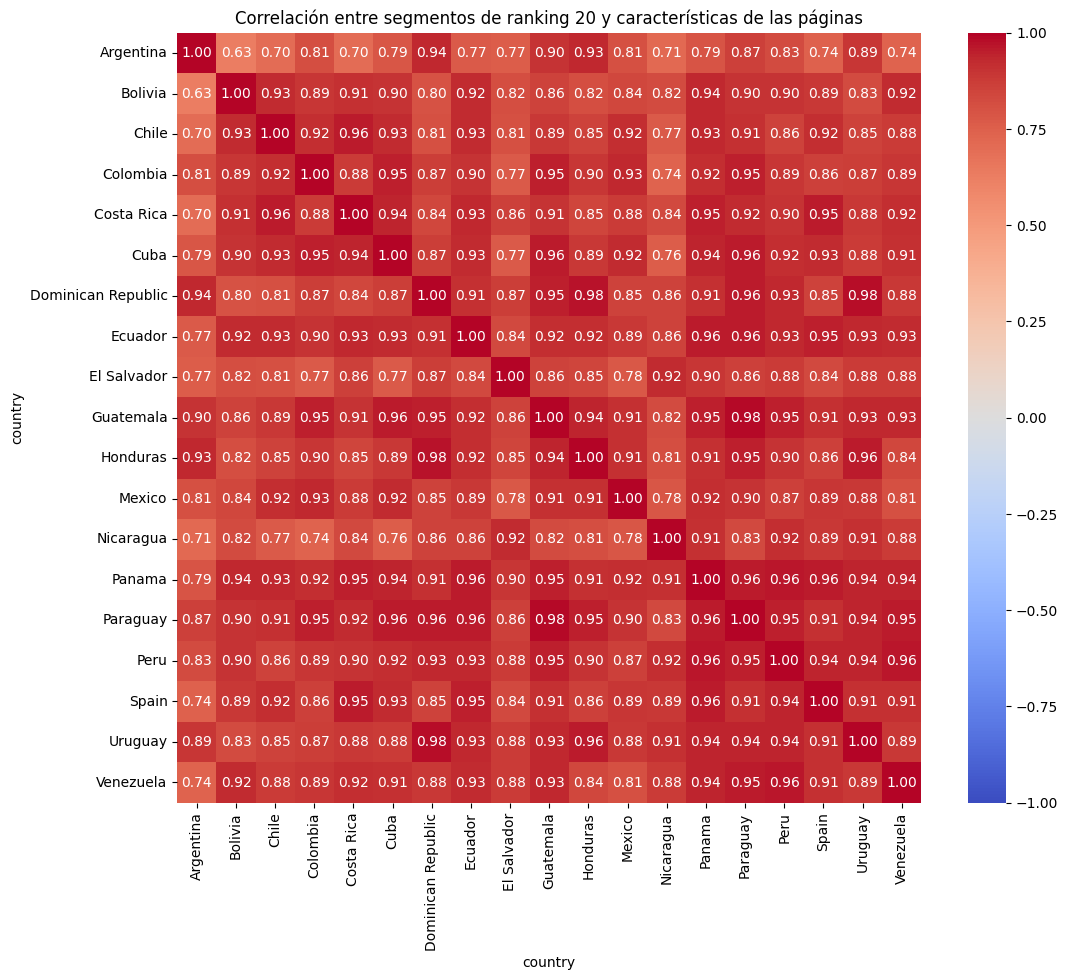

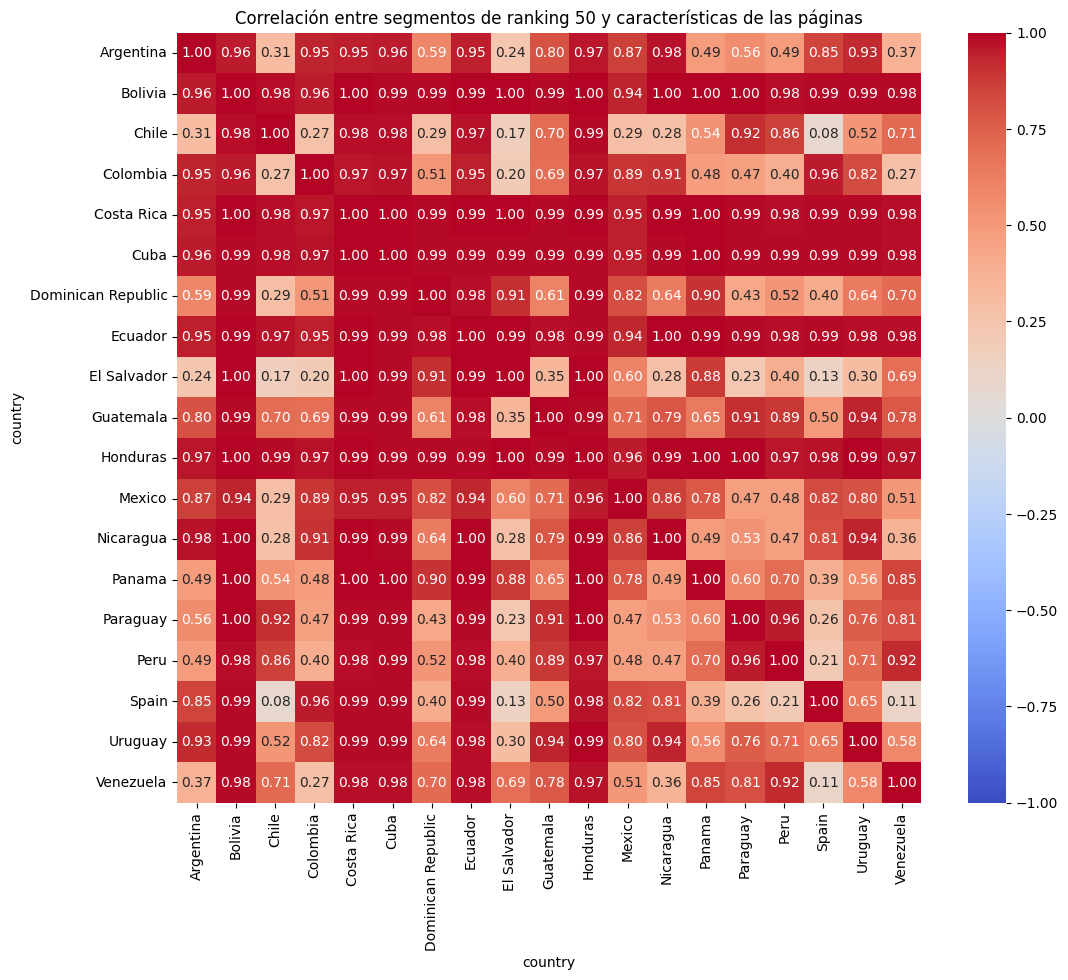

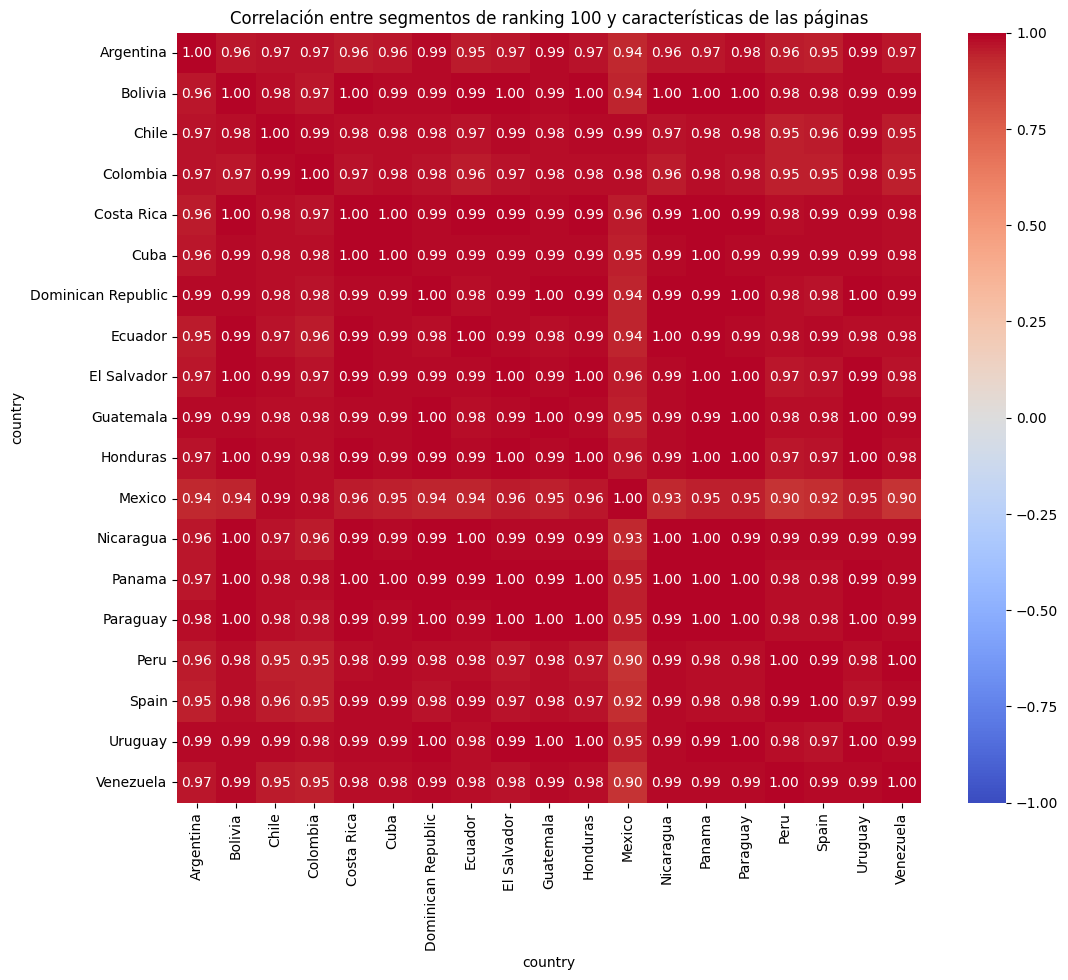

In [88]:
segs = [1,2,5,10,20,50,100]
for s in segs:
    corr_rankings = compute_rank_feature_correlation(df_rankings, df_robertuito, s, 50)
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_rankings, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'Correlación entre segmentos de ranking {s} y características de las páginas')
    plt.show()
